[Interactive Version with SageMathCell](https://olgabelitskaya.github.io/MLE_ND_P3_SMC.html)
# Python Modules & Helpful Functions

In [1]:
import warnings; warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore",category=DataConversionWarning)
import numpy,pandas,pylab,seaborn,time,os
pylab.style.use('seaborn-pastel')
path='../input/wholesale-customers-data-set/'
file='Wholesale customers data.csv'
cmap=seaborn.cubehelix_palette(2,start=.1,rot=-.25,as_cmap=True)
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
os.listdir('../input')

['wholesale-customers-data-set']

In [2]:
# https://github.com/udacity/machine-learning/blob/master/projects/customer_segments/visuals.py
def pca_results(good_data,pca):
    dimensions=['Dimension {}'.format(i) 
                for i in range(1,len(pca.components_)+1)]
    components=pandas.DataFrame(numpy.round(pca.components_,4),
                                columns=good_data.keys())
    components.index=dimensions
    ratios=pca.explained_variance_ratio_.reshape(len(pca.components_),1)
    variance_ratios=pandas.DataFrame(numpy.round(ratios,4),
                                     columns=['Explained Variance'])
    variance_ratios.index=dimensions 
    fig,ax=pylab.subplots(figsize=(11,5))
    components.plot(ax=ax,kind='bar');
    ax.set_ylabel("Feature Weights",fontsize=12)
    ax.set_xticklabels(dimensions,rotation=0)
    for i,ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40,ax.get_ylim()[1]+0.05,
                "Explained Variance \n %.4f"%(ev))
    pylab.grid(); pylab.show()
    return pandas.concat([variance_ratios,components],axis=int(1))
def cluster_results(reduced_data,preds,centers,pca_samples,alg):
    predictions=pandas.DataFrame(preds,columns=['Cluster'])
    plot_data=pandas.concat([predictions,reduced_data],axis=int(1))
    fig,ax=pylab.subplots(figsize=(11,7))
    for i,cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax=ax,kind='scatter',
                     x='Dimension 1',y='Dimension 2',
                     alpha=0.8,edgecolors='slategray',
                     c=cmap((i)*1.0/(len(centers)-1)),
                     label='Cluster %i'%(i),s=30);
    for i,c in enumerate(centers):
        ax.scatter(x=c[0],y=c[1],color='white',edgecolors='black',
                   alpha=1,linewidth=2,marker='o',s=250);
        ax.scatter(x=c[0],y=c[1],marker='$%d$'%(i),
                   alpha=1,s=120,color='black');
        ax.scatter(x=pca_samples[:,0],y=pca_samples[:,1],s=150,
                   linewidth=4,color='#ff5a8b',marker='x');
    ti="%s Cluster Learning on PCA-Reduced Data\n"+\
       "Centroids Marked by Numbers\n"+\
       "Transformed Sample Data Marked by Red Crosses"
    ax.set_title(ti%alg,fontsize=15); pylab.show()
def biplot(good_data,reduced_data,pca):
    fig,ax=pylab.subplots(figsize=(11,7))
    x=reduced_data.loc[:,'Dimension 1']
    y=reduced_data.loc[:,'Dimension 2']
    ax.scatter(x=x,y=y,facecolors='slategray',
               edgecolors=cmap((x*y)**2),s=70,alpha=.4)
    feature_vectors=pca.components_.T
    arrow_size,text_pos=7.,5.
    for i,v in enumerate(feature_vectors):
        ax.arrow(0,0,arrow_size*v[0],arrow_size*v[1],
                 head_width=.2,head_length=.2,
                 linewidth=2,color='#ff5a8b')
        ax.text(v[0]*text_pos,v[1]*text_pos,
                good_data.columns[i],color='black',
                ha='center',va='center',fontsize=12)
    ax.set_xlabel("Dimension 1",fontsize=10)
    ax.set_ylabel("Dimension 2",fontsize=10)
    ax.set_title("PC plane with original feature projections.",
                 fontsize=15); pylab.show()
def channel_results(reduced_data,outliers,pca_samples):
    full_data=pandas.read_csv(path+file)
    channel=pandas.DataFrame(full_data['Channel'],columns=['Channel'])
    channel=channel.drop(channel.index[outliers]).reset_index(drop=True)
    labeled=pandas.concat([reduced_data,channel],axis=int(1))
    fig,ax=pylab.subplots(figsize=(11,5))
    labels=['Hotel/Restaurant/Cafe','Retailer']
    grouped=labeled.groupby('Channel')
    for i,channel in grouped:   
        channel.plot(ax=ax,kind='scatter',
                     x='Dimension 1',y='Dimension 2',
                     color=cmap((i-1)*1.0/2),label=labels[i-1],s=30)  
    for i,sample in enumerate(pca_samples):
        ax.scatter(x=sample[0],y=sample[1],s=230,linewidth=3,
                   color='black',marker='o',facecolors='none');
        ax.scatter(x=sample[0]+0.25,y=sample[1]+0.3,
                   marker='$%d$'%(i),alpha=1,s=200,color='black')
    ti="PCA-Reduced Data Labeled by 'Channel'\n"+\
       "Transformed Sample Data Circled"
    ax.set_title(ti,fontsize=15); pylab.show()

In [3]:
def split_fit():
    X_train,X_test,y_train,y_test=\
    train_test_split(new_data,target,test_size=0.25,random_state=1)
    print ("Training and testing splitting was successful.")
    regressor1=DecisionTreeRegressor(random_state=1)
    regressor1.fit(X_train,y_train)
    regressor2=RandomForestRegressor(random_state=1)
    regressor2.fit(X_train,y_train)
    score1=regressor1.score(X_test,y_test)
    score2=regressor2.score(X_test,y_test)
    st1="Decision Tree Regressor. "
    st2="Random Forest Regressor. "
    st3="The score of the prediction using the testing set is {}."
    print(st1+st3.format(score1)); print(st2+st3.format(score2))
    return regressor1,regressor2
def plot_feature_importance(f,regressor1,regressor2):
    D1=dict(zip(new_data,regressor1.feature_importances_))
    D2=dict(zip(new_data,regressor2.feature_importances_))
    pylab.figure(figsize=(11,5)); 
    pylab.subplot(121); pylab.grid()
    pylab.bar(range(len(D1)),D1.values(),alpha=.5,
              color='slategrey',align='center')
    pylab.xticks(range(len(D1)),D1.keys(),fontsize=7)
    st='Experiment with "%s": Feature Importances, \n'
    pylab.title(st%f+'Decision Tree Regressor')
    pylab.subplot(122); pylab.grid()
    pylab.bar(range(len(D2)),D2.values(),alpha=.5,
              color='slategrey',align='center')
    pylab.xticks(range(len(D2)),D2.keys(),fontsize=7)
    pylab.title(st%f+'Random Forest Regressor'); pylab.show()

# Data

In [4]:
data=pandas.read_csv(path+file)
data.drop(['Region','Channel'],axis=1,inplace=True)
data.columns=['Fresh','Milk','Grocery',
              'Frozen','Detergents_Paper','Delicatessen']
ti="The dataset has {} samples with {} features each."
print(ti.format(*data.shape)); data.describe().T

The dataset has 440 samples with 6 features each.


,count,mean,std,min,25%,50%,75%,max
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicatessen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


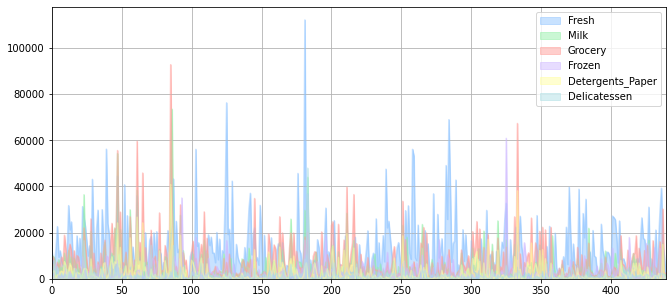

In [5]:
data.plot.area(stacked=False,figsize=(11,5))
pylab.grid(); pylab.show()

Chosen samples of the wholesale customers' dataset:


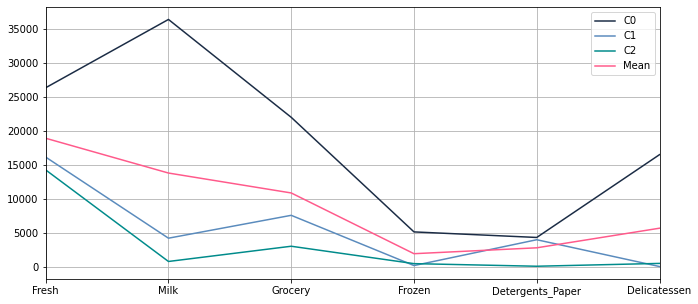

In [6]:
# selecting samples
indices=[23,25,27]
def hex_to_rgb(chex):
        chex=chex.lstrip('#'); n=len(chex)
        return tuple(int(chex[i:i+n//3],16)/255. for i in range(0,n,n//3))
samples=pandas.DataFrame(data.loc[indices],
                         columns=data.keys()).reset_index(drop=True)
samples.index=['C0','C1','C2']; samples.loc['Mean']=samples.mean()
print ("Chosen samples of the wholesale customers' dataset:"); samples
cols=['#1b2c45','#5a8bbd','#008b8b','#ff5a8b']
samples.T.plot(figsize=(11,5),color=[hex_to_rgb(el) for el in cols])
pylab.grid(); pylab.show()

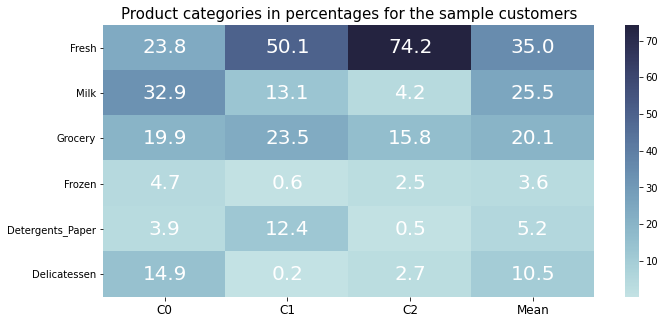

In [7]:
pylab.figure(figsize=(11,5))
p_samples=samples.iloc[:].T.apply(lambda x:100.0*x/x.sum())
seaborn.heatmap(p_samples,cmap=cmap,annot=True,
                annot_kws={"color":"White","size":20},fmt='.1f')
ti="Product categories in percentages for the sample customers"
pylab.title(ti,fontsize=15)
pylab.xticks(ha='center',fontsize=12)
pylab.yticks(fontsize=10); pylab.show()

# Feature Relevance
### Experiment with Delicatessen

In [8]:
new_data=data.drop('Delicatessen',axis=int(1))
target=data['Delicatessen']
new_data_target=pandas.concat([new_data,target],axis=int(1))
print ("The correlation table for the choosen feature 'Delicatessen'")
pearson=new_data_target.corr(method='pearson')
corr_with_delicatessen=pearson.iloc[int(-1)][:-int(1)]
corr_with_delicatessen[abs(corr_with_delicatessen).argsort()[::-int(1)]]

The correlation table for the choosen feature 'Delicatessen'


Milk                0.406368
Frozen              0.390947
Fresh               0.244690
Grocery             0.205497
Detergents_Paper    0.069291
Name: Delicatessen, dtype: float64

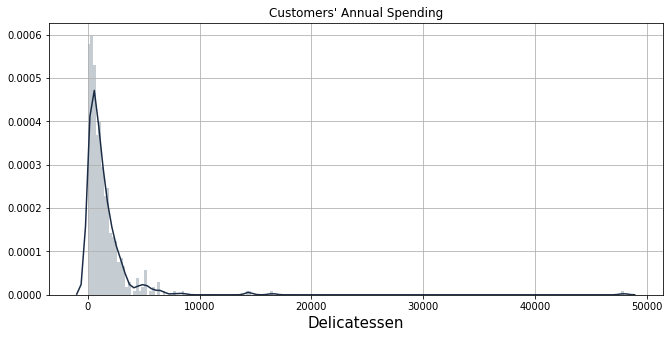

In [9]:
pylab.figure(figsize=(11,5))
seaborn.distplot(target,color='#1b2c45',bins=200,
                 hist_kws={'color':'SlateGrey'})
pylab.xlabel("Delicatessen",fontsize=15)
pylab.title("Customers' Annual Spending",fontsize=12)
pylab.grid(); pylab.show()

Training and testing splitting was successful.
Decision Tree Regressor. The score of the prediction using the testing set is -0.4291251956585451.
Random Forest Regressor. The score of the prediction using the testing set is -0.9356668413799336.


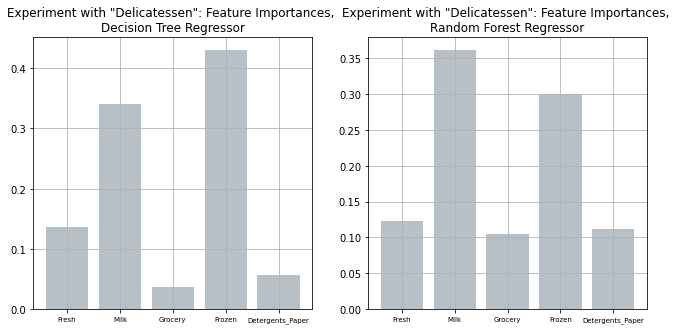

In [10]:
regressor1,regressor2=split_fit()
plot_feature_importance('Delicatessen',regressor1,regressor2)

### Experiment with Grocery

In [11]:
new_data=data.drop('Grocery',axis=int(1)); target=data['Grocery']
new_data_target=pandas.concat([new_data,target],axis=int(1))
print ("The correlation table for the choosen feature 'Grocery'")
pearson=new_data_target.corr(method='pearson')
corr_with_grocery=pearson.iloc[int(-1)][:-int(1)]
corr_with_grocery[abs(corr_with_grocery).argsort()[::-int(1)]]

The correlation table for the choosen feature 'Grocery'


Detergents_Paper    0.924641
Milk                0.728335
Delicatessen        0.205497
Frozen             -0.040193
Fresh              -0.011854
Name: Grocery, dtype: float64

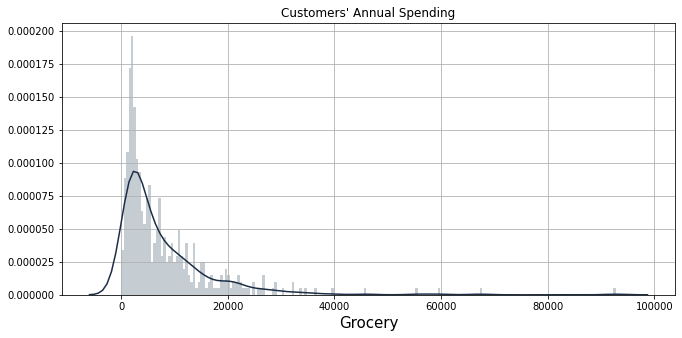

In [12]:
pylab.figure(figsize=(11,5))
seaborn.distplot(target,color='#1b2c45',bins=200,
                 hist_kws={'color':'SlateGrey'})
pylab.xlabel("Grocery",fontsize=15)
pylab.title("Customers' Annual Spending",fontsize=12)
pylab.grid(); pylab.show()

Training and testing splitting was successful.
Decision Tree Regressor. The score of the prediction using the testing set is 0.7957683115761958.
Random Forest Regressor. The score of the prediction using the testing set is 0.8447104305730341.


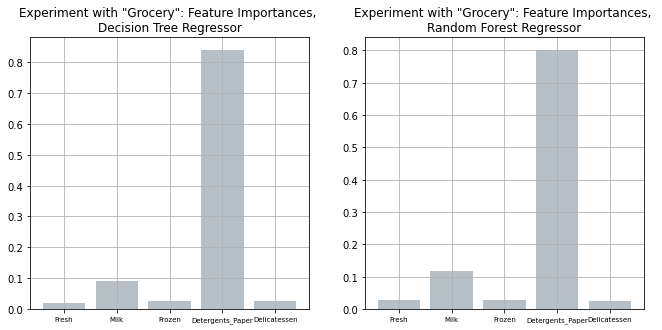

In [13]:
regressor1,regressor2=split_fit()
plot_feature_importance('Grocery',regressor1,regressor2)

### Feature Distributions

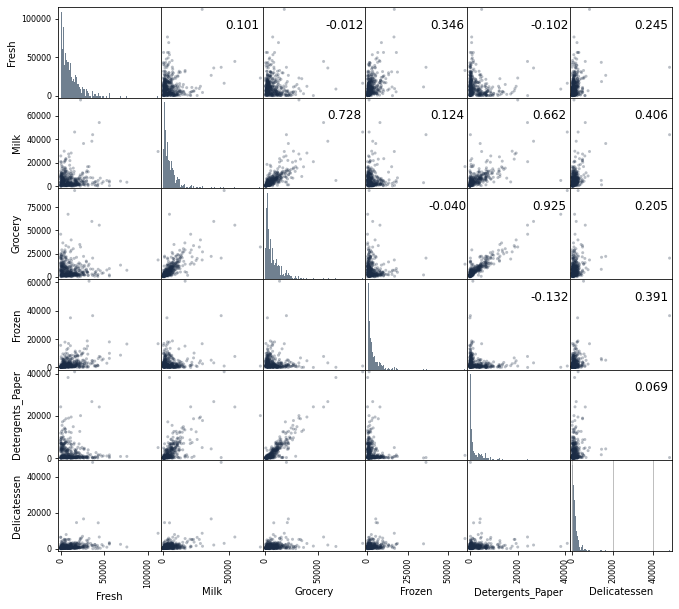

In [14]:
axes=pandas.plotting.scatter_matrix(data,alpha=.3,figsize=(11,10),
                                    diagonal='hist',c='#1b2c45',
                                    hist_kwds={'color':'SlateGrey','bins':100})
corr=data.corr().values
for i,j in zip(*numpy.triu_indices_from(axes,k=1)):
    axes[i,j].annotate("%.3f" %corr[i,j],(.8,.8),fontsize=12,
                       xycoords='axes fraction',ha='center',va='center')
pylab.grid(); pylab.show()

In [15]:
print ("Pearson correlation coefficients")
data.corr(method='pearson')

Pearson correlation coefficients


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


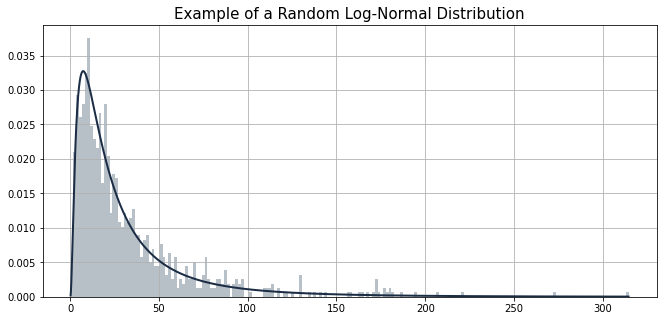

In [16]:
pylab.figure(figsize=(11,5)); mu,sigma=3.,1.
s=numpy.random.lognormal(mu,sigma,1000)
count,bins,ignored=pylab.hist(s,200,align='mid',density=True,
                              alpha=.5,color='slategrey')
x=numpy.linspace(min(bins),max(bins),10000)
pdf=(numpy.exp(-(numpy.log(x)-mu)**2/(2*sigma**2))\
     /(x*sigma*numpy.sqrt(2*numpy.pi)))
pylab.plot(x,pdf,linewidth=2,color='#1b2c45')
pylab.axis('tight'); pylab.grid()
pylab.title('Example of a Random Log-Normal Distribution',
            fontsize=15); pylab.show()

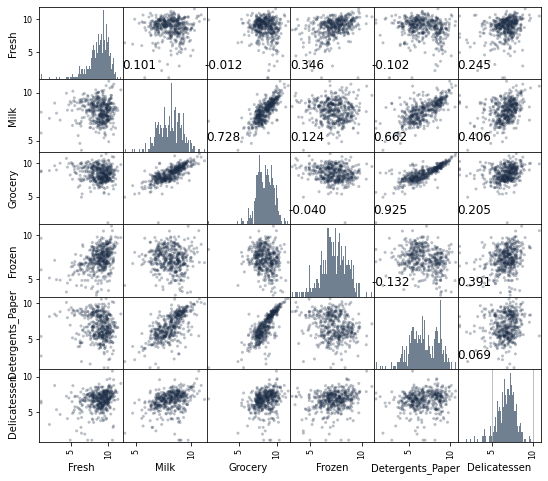

In [17]:
log_data=numpy.log(data); log_samples=numpy.log(samples)
corr=data.corr().values
axes=pandas.plotting.scatter_matrix(log_data,alpha=.3,figsize=(9,8),
                                    diagonal='hist',c='#1b2c45',
                                    hist_kwds={'color':'SlateGrey','bins':100})
for i,j in zip(*numpy.triu_indices_from(axes,k=1)):
    axes[i,j].annotate("%.3f" %corr[i,j],(.2,.2),fontsize=12,
                       xycoords='axes fraction',ha='center',va='center')
pylab.grid(); pylab.show()

In [18]:
log_samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
C0,10.180096,10.502956,9.999661,8.547528,8.374938,9.712509
C1,9.690604,8.349957,8.935245,5.303305,8.294799,4.043051
C2,9.566335,6.688355,8.021256,6.184149,4.605170,6.249975
Mean,9.848926,9.533776,9.295263,7.573874,7.942125,8.648104


In [19]:
print ("Pearson correlation coefficients")
log_data.corr(method='pearson')

Pearson correlation coefficients


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,-0.019834,-0.132713,0.383996,-0.155871,0.255186
Milk,-0.019834,1.000000,0.758851,-0.055316,0.677942,0.337833
Grocery,-0.132713,0.758851,1.000000,-0.164524,0.796398,0.235728
Frozen,0.383996,-0.055316,-0.164524,1.000000,-0.211576,0.254718
Detergents_Paper,-0.155871,0.677942,0.796398,-0.211576,1.000000,0.166735
Delicatessen,0.255186,0.337833,0.235728,0.254718,0.166735,1.000000


# Outlier Detection

In [20]:
for feature in log_data.keys():
    Q1,Q3=numpy.percentile(log_data[feature],25),\
          numpy.percentile(log_data[feature],75)
    step=(Q3-Q1)*1.5
    st="Data points considered outliers for the feature '{}':"
    print(st.format(feature))
    display(log_data[~((log_data[feature]>=Q1-step)&(log_data[feature]<=Q3+step))])
outliers=[65,66,75,128,154]
print("Data outliers: '{}'".format(outliers))
good_data=log_data.drop(log_data.index[outliers]).reset_index(drop=True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Data outliers: '[65, 66, 75, 128, 154]'


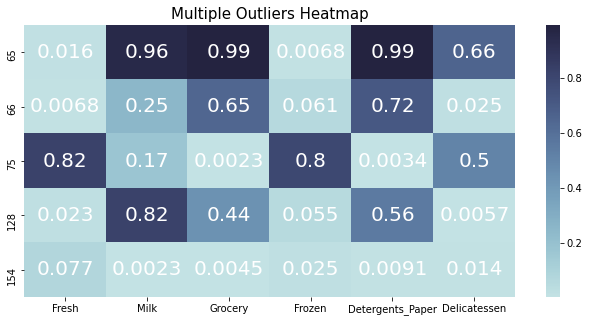

In [21]:
out_percentiles=data.rank(pct=True).iloc[outliers]
pylab.figure(figsize=(11,5))
pylab.xticks(fontsize=10); pylab.yticks(fontsize=10)
seaborn.heatmap(out_percentiles,annot=True,cmap=cmap,
                annot_kws={'color':'White','size':'20'})
pylab.title('Multiple Outliers Heatmap',fontsize=15); pylab.show()

# Feature Transformation

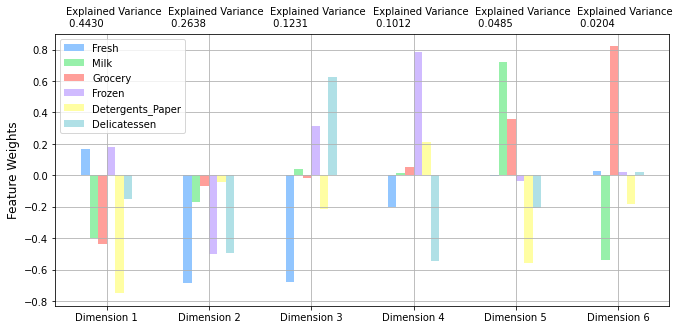

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941
Dimension 3,0.1231,-0.6774,0.0402,-0.0195,0.3150,-0.2117,0.6286
Dimension 4,0.1012,-0.2043,0.0128,0.0557,0.7854,0.2096,-0.5423
Dimension 5,0.0485,-0.0026,0.7192,0.3554,-0.0331,-0.5582,-0.2092
Dimension 6,0.0204,0.0292,-0.5402,0.8205,0.0205,-0.1824,0.0197


In [22]:
pca=PCA(n_components=len(good_data.keys())).fit(good_data)
pca_samples=pca.transform(log_samples) 
pca_result=pca_results(good_data,pca); pca_result

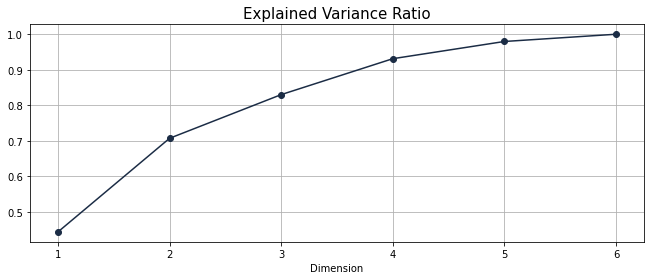

The first and second principal components explained 70.67999999999999%
The first four principal components explained 93.11%


In [23]:
pylab.figure(figsize=(11,4))
pylab.xlabel('Dimension',fontsize=10)
pylab.plot(numpy.arange(1,7),
           numpy.cumsum(pca.explained_variance_ratio_),
           '-o',c='#1b2c45')
pylab.title('Explained Variance Ratio',fontsize=15)
pylab.grid(); pylab.show()
print ("The first and second principal components explained {}%"\
.format(sum(pca_result['Explained Variance'][:int(2)])*100.0))
print ("The first four principal components explained {}%"\
.format(sum(pca_result['Explained Variance'][:int(4)])*100.0))

In [24]:
pandas.DataFrame(numpy.round(pca_samples,4),
                 columns=pca_result.index.values,
                 index=['C0','C1','C2','Mean'])

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
C0,-2.8096,-3.6459,1.0567,-0.5186,0.6999,-0.1811
C1,-1.2292,1.5540,-3.2462,0.0043,0.1124,-0.0697
C2,2.4162,0.6069,-0.7652,-1.3209,0.1614,0.8089
Mean,-1.8561,-2.1752,0.3717,-0.7808,0.2498,-0.2072


In [25]:
pca=PCA(n_components=2).fit(good_data)
pca_samples=pca.transform(log_samples)
reduced_data=pandas.DataFrame(pca.transform(good_data),
                              columns=['Dimension 1','Dimension 2'])
pandas.DataFrame(numpy.round(pca_samples,4),
                 columns=['Dimension 1','Dimension 2'],
                 index=['C0','C1','C2','Mean'])

,Dimension 1,Dimension 2
C0,-2.8096,-3.6459
C1,-1.2292,1.5540
C2,2.4162,0.6069
Mean,-1.8561,-2.1752


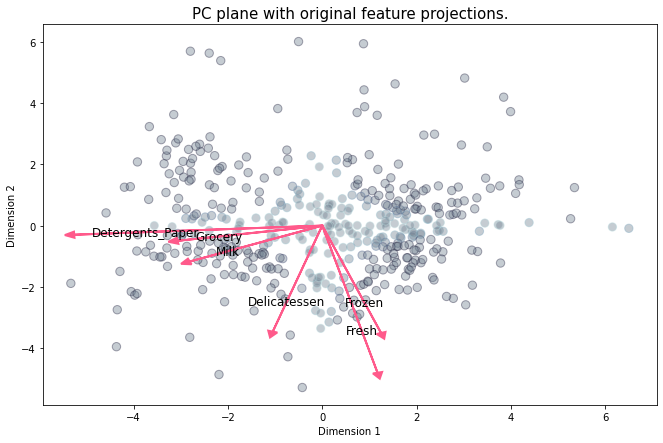

In [26]:
biplot(good_data,reduced_data,pca)

# Creating Clusters

In [27]:
for n in list(range(2,12)):
    clusterer=KMeans(n_clusters=n).fit(reduced_data)
    preds=clusterer.predict(reduced_data)
    centers=clusterer.cluster_centers_
    sample_preds=clusterer.predict(pca_samples)
    score=silhouette_score(reduced_data,preds)
    st="For number of clusters = {}, the silhouette_score is : {}"
    print(st.format(n,score))

For number of clusters = 2, the silhouette_score is : 0.42628101546910835
For number of clusters = 3, the silhouette_score is : 0.3974234200078323
For number of clusters = 4, the silhouette_score is : 0.33224062994679227
For number of clusters = 5, the silhouette_score is : 0.352208874352643
For number of clusters = 6, the silhouette_score is : 0.3645888815791821
For number of clusters = 7, the silhouette_score is : 0.3648753591099507
For number of clusters = 8, the silhouette_score is : 0.364577560751949
For number of clusters = 9, the silhouette_score is : 0.36320243113707473
For number of clusters = 10, the silhouette_score is : 0.35002784944891613
For number of clusters = 11, the silhouette_score is : 0.3477263783111335


In [28]:
for n in list(range(2,12)):
    clusterer2=GaussianMixture(n_components=n,
                               covariance_type='full').fit(reduced_data)
    preds2=clusterer2.predict(reduced_data); centers2=clusterer2.means_
    sample_preds2=clusterer2.predict(pca_samples)
    score2=silhouette_score(reduced_data,preds2,metric='mahalanobis')
    print("For number of clusters = {}, the silhouette_score is : {}"\
          .format(n,score2))

For number of clusters = 2, the silhouette_score is : 0.37615565776759097
For number of clusters = 3, the silhouette_score is : 0.342254608880423
For number of clusters = 4, the silhouette_score is : 0.3311640755953448
For number of clusters = 5, the silhouette_score is : 0.29678990056347526
For number of clusters = 6, the silhouette_score is : 0.3143192048738332
For number of clusters = 7, the silhouette_score is : 0.3200633234875808
For number of clusters = 8, the silhouette_score is : 0.29015605819299645
For number of clusters = 9, the silhouette_score is : 0.3207396655595931
For number of clusters = 10, the silhouette_score is : 0.24155506273032418
For number of clusters = 11, the silhouette_score is : 0.31472504240086985


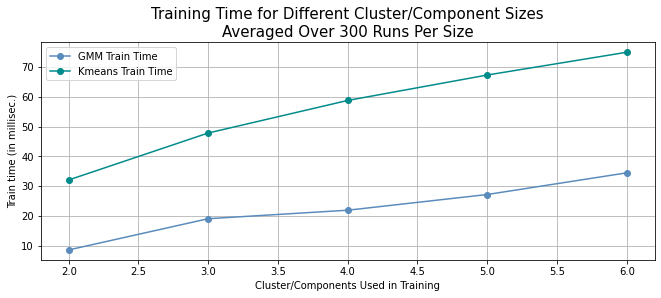

In [29]:
n,k=300,6; kmeans_train_times=[]; gmm_train_times=[]
for k in range(2,k+1):
    cum_time=0.
    for i in range(n):
        start=time.time()
        KMeans(n_clusters=k).fit(reduced_data)
        cum_time+=(time.time()-start)
    kmeans_train_times.append([k,cum_time/n])
km_df=pandas.DataFrame(kmeans_train_times,
                       columns=['KM_Clusters','KM_Time'])
for k in range(2,k+1):
    cum_time=0.
    for i in range(n):
        start=time.time()
        GaussianMixture(n_components=k).fit(reduced_data)
        cum_time+=(time.time()-start)
    gmm_train_times.append([k,cum_time/n])
gmm_df=pandas.DataFrame(gmm_train_times,
                        columns=['GMM_Components','GMM_Time'])
times_df=km_df.join(gmm_df)
pylab.figure(figsize=(11,4))
pylab.plot(times_df.GMM_Components,times_df.GMM_Time*1000.,
           '-o',c='#5a8bbd',label='GMM Train Time')
pylab.plot(times_df.GMM_Components,times_df.KM_Time*1000.,
           '-o',c='#008b8b',label='Kmeans Train Time')
pylab.ylabel('Train time (in millisec.)',fontsize=10)
pylab.xlabel('Cluster/Components Used in Training',fontsize=10)
st='Training Time for Different Cluster/Component Sizes\n'+\
   'Averaged Over {} Runs Per Size'
pylab.title(st.format(n),fontsize=15)
pylab.legend(loc='best'); pylab.grid(); pylab.show()

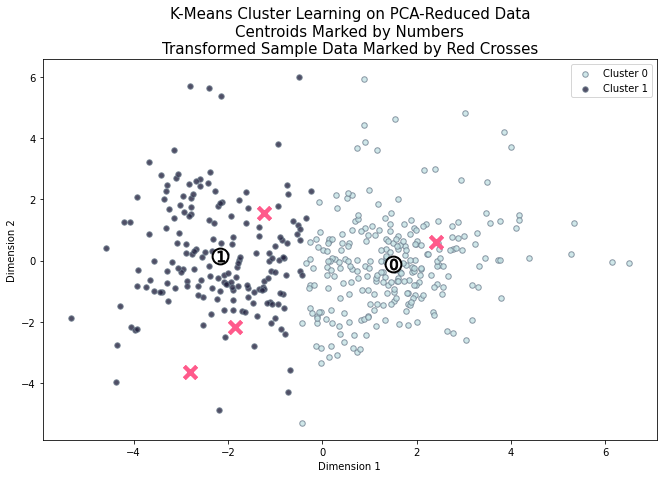

In [30]:
clusterer=KMeans(n_clusters=2).fit(reduced_data)
sample_preds=clusterer.predict(pca_samples)
preds=clusterer.predict(reduced_data)
centers=clusterer.cluster_centers_
score=silhouette_score(reduced_data,preds)
cluster_results(reduced_data,preds,centers,pca_samples,'K-Means')

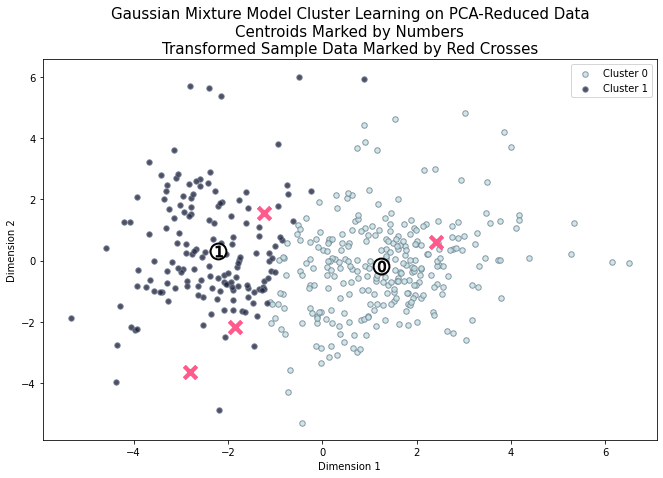

In [31]:
clusterer2=GaussianMixture(n_components=2,
                           covariance_type='full').fit(reduced_data)
sample_preds2=clusterer2.predict(pca_samples)
preds2=clusterer2.predict(reduced_data)
centers2=clusterer2.means_; score2=silhouette_score(reduced_data,preds2)
cluster_results(reduced_data,preds2,centers2,
                pca_samples,'Gaussian Mixture Model')

In [32]:
print ("Data Means")
pandas.DataFrame(numpy.mean(data)).T

Data Means


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455


In [33]:
log_centers=pca.inverse_transform(centers)
true_centers=numpy.exp(log_centers)
segments=['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers=pandas.DataFrame(numpy.round(true_centers),
                              columns=data.keys(),index=segments)
print ("K-Means True Centers"); true_centers

K-Means True Centers


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8867.0,1897.0,2477.0,2088.0,294.0,681.0
Segment 1,4005.0,7900.0,12104.0,952.0,4561.0,1036.0


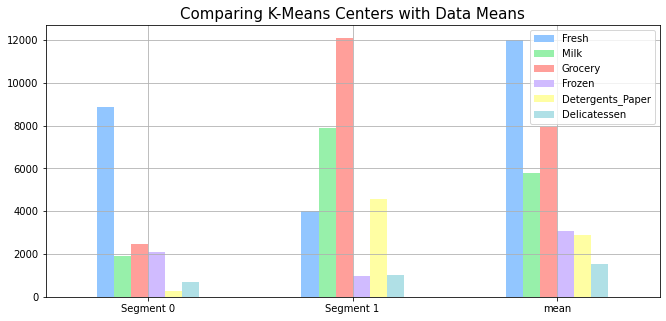

In [34]:
true_centers=true_centers.append(data.describe().loc['mean'])
true_centers.plot(kind='bar',figsize=(11,5))
pylab.title('Comparing K-Means Centers with Data Means',fontsize=15)
pylab.xticks(rotation=0,fontsize=10); pylab.grid(); pylab.show()

In [35]:
log_centers2=pca.inverse_transform(centers2)
true_centers2=numpy.exp(log_centers2)
segments2=['Segment {}'.format(i) for i in range(0,len(centers2))]
true_centers2=pandas.DataFrame(numpy.round(true_centers2),
                               columns=data.keys(),index=segments2)
print ("Gaussian Mixture Model True Centers"); true_centers2

Gaussian Mixture Model True Centers


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


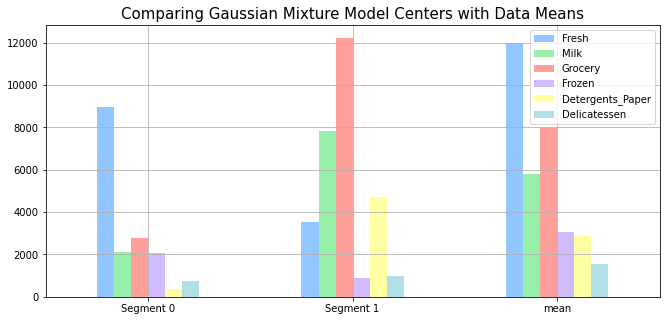

In [36]:
true_centers2=true_centers2.append(data.describe().loc['mean'])
true_centers2.plot(kind='bar',figsize=(11,5))
st='Comparing Gaussian Mixture Model Centers with Data Means'
pylab.title(st,fontsize=15)
pylab.xticks(rotation=0,fontsize=10); pylab.grid(); pylab.show()

In [37]:
clusters=pandas.DataFrame(2*[['','']],
                          columns=['K-Means','Gaussian Mixture'],
                          index=['Segment 0','Segment 1'])
if true_centers['Fresh']['Segment 0']>true_centers['Fresh']['Segment 1']:
    clusters['K-Means']['Segment 0']='HoReCa'
    clusters['K-Means']['Segment 1']='Retail'
else: 
    clusters['K-Means']['Segment 0']='Retail'
    clusters['K-Means']['Segment 1']='HoReCa'
if true_centers2['Fresh']['Segment 0']>true_centers2['Fresh']['Segment 1']:
    clusters['Gaussian Mixture']['Segment 0']='HoReCa'
    clusters['Gaussian Mixture']['Segment 1']='Retail'
else: 
    clusters['Gaussian Mixture']['Segment 0']='Retail'
    clusters['Gaussian Mixture']['Segment 1']='HoReCa'
clusters

,K-Means,Gaussian Mixture
Segment 0,HoReCa,HoReCa
Segment 1,Retail,Retail


In [38]:
clusters2=pandas.DataFrame(3*[['','']],
                           columns=['K-Means','Gaussian Mixture'],
                           index=['C0','C1','C2'])
clusters2['Cluster']=['Retail','Retail','HoReCa']
for el in ['K-Means','Gaussian Mixture']:
    if clusters[el].values[0]=='Retail': 
        clusters2[el]=['Segment 0','Segment 0','Segment 1']
    else: 
        clusters2[el]=['Segment 1','Segment 1','Segment 0']
clusters2

,K-Means,Gaussian Mixture,Cluster
C0,Segment 1,Segment 1,Retail
C1,Segment 1,Segment 1,Retail
C2,Segment 0,Segment 0,HoReCa


In [39]:
st1="Sample point {} predicted to be in Cluster {}"
st2="The distance between sample point {} and center of Cluster {}:"
print ("K-Means")
for i,pred in enumerate(sample_preds):
    print (st1.format(i,pred))
    print (st2.format(i,pred))
    print (samples.iloc[i]-true_centers.iloc[pred])
print ("\n\nGaussian Mixture Model")
for i,pred in enumerate(sample_preds2):
    print (st1.format(i,pred))
    print (st2.format(i,pred))
    print (samples.iloc[i]-true_centers2.iloc[pred])

K-Means
Sample point 0 predicted to be in Cluster 1
The distance between sample point 0 and center of Cluster 1:
Fresh               22368.0
Milk                28523.0
Grocery              9915.0
Frozen               4202.0
Detergents_Paper     -224.0
Delicatessen        15487.0
dtype: float64
Sample point 1 predicted to be in Cluster 1
The distance between sample point 1 and center of Cluster 1:
Fresh               12160.0
Milk                -3670.0
Grocery             -4509.0
Frozen               -751.0
Detergents_Paper     -558.0
Delicatessen         -979.0
dtype: float64
Sample point 2 predicted to be in Cluster 0
The distance between sample point 2 and center of Cluster 0:
Fresh               5409.0
Milk               -1094.0
Grocery              568.0
Frozen             -1603.0
Detergents_Paper    -194.0
Delicatessen        -163.0
dtype: float64
Sample point 3 predicted to be in Cluster 1
The distance between sample point 3 and center of Cluster 1:
Fresh               14933.000

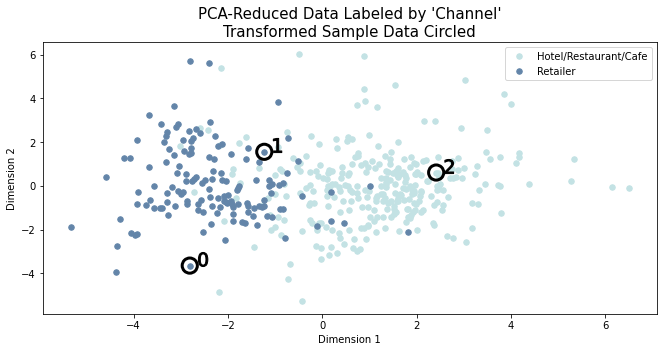

In [40]:
channel_results(reduced_data,outliers,pca_samples[:3])

In [41]:
channel_data=pandas.read_csv(path+file)
channel_data=channel_data.drop(channel_data.index[outliers])\
                         .reset_index(drop=True)
# Might need to switch around the 0 and 1, based on the cluster seed
[df1,df2]=[numpy.where(channel_data['Channel']==2,0,1),
           numpy.where(channel_data['Channel']==2,1,0)]
percentage_kmeans=max(sum(df1==preds)/float(len(preds)),
                      sum(df2==preds)/float(len(preds)))
percentage_gaussian_mixture=max(sum(df1==preds)/float(len(preds2)),
                                sum(df2==preds2)/float(len(preds2)))
print ("K-Means")
print ("Percentage of correctly classified customers: {:.2%}"\
.format(percentage_kmeans))
print ("\nGaussian Mixture Model")
print ("Percentage of correctly classified customers: {:.2%}"\
.format(percentage_gaussian_mixture))

K-Means
Percentage of correctly classified customers: 88.97%

Gaussian Mixture Model
Percentage of correctly classified customers: 90.11%
